In [2]:
"""
Demonstration of DUNE plot style using PyROOT.
(These are simple translations of the C++ script in ../cpp/example.C.)

Original authors:  Young DUNE plot style task force
     Comments to:  Authorship & publications board (dune-apb@fnal.gov)
"""

import ctypes
import ROOT
import dunestyle.root as dunestyle

ROOT.gROOT.SetBatch(True)
ROOT.EnableThreadSafety()

#ROOT.gInterpreter.Declare('TF1 f("f", "gaus(0)", -100, 100, 1);')

f = ROOT.TF1("f", "gaus(0)", -100, 100, 1)

# save a lot of useless repetitive typing
def MakeLegend(left=0.7, bottom=0.5, right=0.9, top=0.85):
	leg = ROOT.TLegend(left, bottom, right, top)
	leg.SetFillStyle(0)  # unfortunately can't set this in TStyle :(
	return leg

Warning in <TROOT::Append>: Replacing existing TH1: example1d (Potential memory leak).


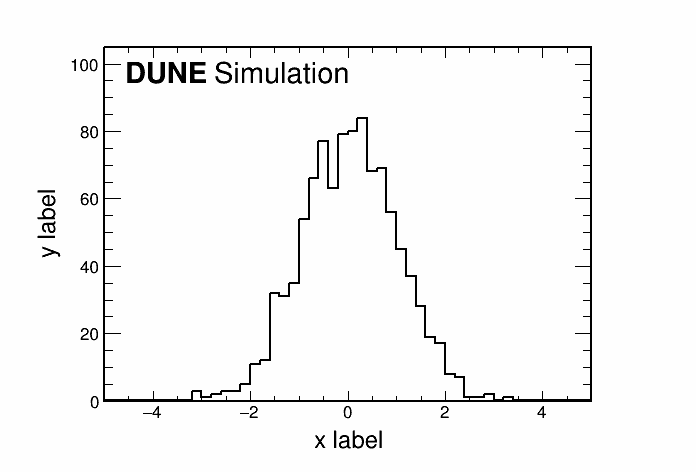

In [17]:
#-------------------------------------------------------------------
def OneDHistExample(c):
	h1D = ROOT.TH1D("example1d", ";x label;y label", 50, -5, 5)
	leg = MakeLegend(0.65, 0.7, 0.9, 0.85)
	ROOT.SetOwnership(h1D, False)
	h1D.FillRandom("gaus", 1000)
	h1D.Draw()
	h1D.SetMaximum(h1D.GetMaximum()*1.25)  # make room for watermark
	dunestyle.CenterTitles(h1D)
	dunestyle.Simulation()
#-------------------------------------------------------------------

c = ROOT.TCanvas()
OneDHistExample(c)
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: exampledata (Potential memory leak).


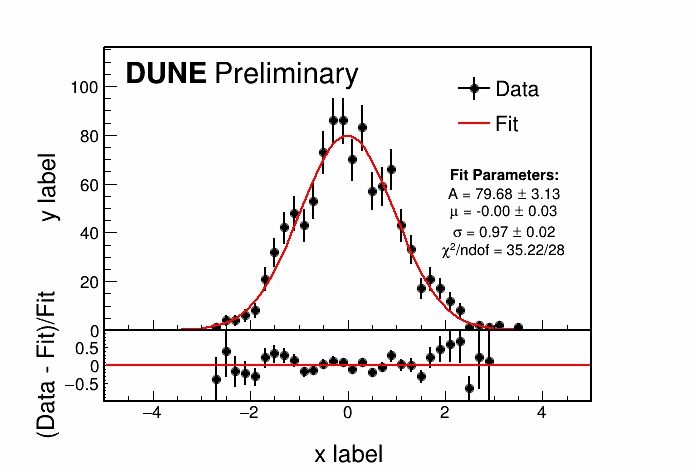

In [13]:
#-------------------------------------------------------------------
def DataMCExample(c):
	""" 1D data/mc comparison type plot """
	c.cd()
	c.Clear()
	leg = MakeLegend(0.65, 0.7, 0.9, 0.85)
	ROOT.SetOwnership(leg, False)
	
	h1D = ROOT.TH1D("exampledata", ";x label;y label", 50, -5, 5)
	ROOT.SetOwnership(h1D, False)
	h1D.FillRandom("gaus", 1000)
	dunestyle.CenterTitles(h1D)
	
	h1D_ratio = h1D.Clone("h1D_ratio")
	ROOT.SetOwnership(h1D_ratio, False)
	p1 = ROOT.TPad()
	ROOT.SetOwnership(p1, False)
	p2 = ROOT.TPad()
	ROOT.SetOwnership(p2, False)
	dunestyle.SplitCanvas(c, 0.3, p1, p2)
	c.cd(); p1.Draw(); p1.cd()
	h1D_ratio.GetXaxis().SetTitleOffset(1.25)
	h1D_ratio.GetYaxis().SetTitle("(Data - Fit)/Fit")
	leg.Clear()
	h1D.Fit("gaus", "Q")
	h1D.Draw("E")
	fit = h1D.GetFunction("gaus")
	leg.AddEntry(h1D,"Data","lep")
	leg.AddEntry(fit,"Fit","l")
	leg.Draw()
	h1D.GetYaxis().SetRangeUser(h1D.GetMinimum(), h1D.GetMaximum()*1.35)  # make room for watermark
	dunestyle.Preliminary()
	
	h1D_ratio.Sumw2()
	h1D_ratio.Add(fit, -1)
	h1D_ratio.Divide(fit)
	zero = ROOT.TF1("zero","0.",-5,5)
	ROOT.SetOwnership(zero, False)
	dunestyle.CenterTitles(h1D_ratio)
	c.cd(); p2.Draw(); p2.cd()
	h1D_ratio.GetYaxis().SetRangeUser(-0.99,0.99)
	h1D_ratio.Draw("E")
	zero.Draw("same")
	
	p1.cd()
	pave = ROOT.TPaveText(0.6, 0.45, 0.85, 0.65, "NDC NB")
	ROOT.SetOwnership(pave, False)
	pave.SetBorderSize(0)
	pave.SetFillStyle(0)
	pave.SetTextSizePixels(35)
	head = pave.AddText("Fit Parameters:")
	head.SetTextFont(62)
	pave.AddText("A = %.2f #pm %.2f" % (fit.GetParameter(0), fit.GetParError(0)))
	pave.AddText("#mu = %.2f #pm %.2f" % (fit.GetParameter(1), fit.GetParError(1)))
	pave.AddText("#sigma = %.2f #pm %.2f" % (fit.GetParameter(2), fit.GetParError(2)))
	pave.AddText("#chi^{2}/ndof = %.2f/%d" % (fit.GetChisquare(), fit.GetNDF()))
	pave.Draw()
#-------------------------------------------------------------------

DataMCExample(c)
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: example2d (Potential memory leak).


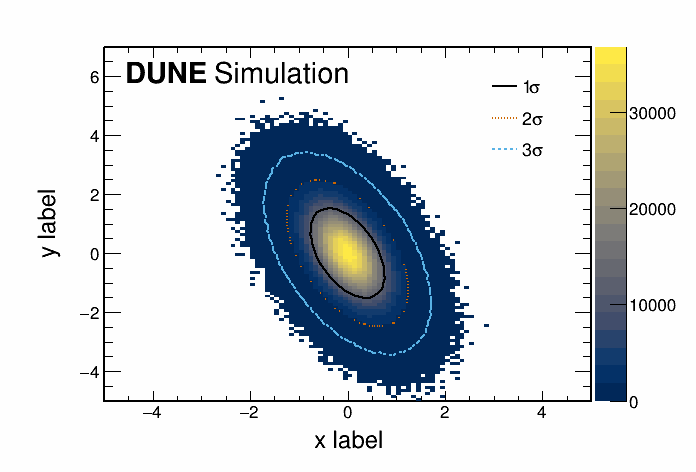

In [14]:
#-------------------------------------------------------------------
def TwoDExample(c):
	c.Clear()
	c.cd()
	leg = MakeLegend(0.7, 0.65, 0.9, 0.85)
	ROOT.SetOwnership(leg, False)

	h2d = ROOT.TH2D("example2d", ";x label;y label", 100, -5, 5, 120, -5, 7)
	ROOT.SetOwnership(h2d, False)
	cust_gaus_2d = ROOT.TF2("cust_gaus_2d","ROOT::Math::bigaussian_pdf(x,y,0.5,1.0,-0.5,0,0)")
	ROOT.SetOwnership(cust_gaus_2d, False)
	h2d.FillRandom("cust_gaus_2d", int(1e7))
	dunestyle.CenterTitles(h2d)
	h2d.Draw("colz")
	dunestyle.Simulation()

	# compute the contour levels.
	# this is a clumsy way of getting the cumulative distribution function
	tmp = ROOT.TH1D("tmp", "tmp", int(h2d.GetMaximum()+1), 0, h2d.GetMaximum()+1)
	for i in range(h2d.GetNcells()+1):
		tmp.Fill(h2d.GetBinContent(i), h2d.GetBinContent(i))
	cutoffs = [0.997, 0.954, 0.682]
	levels = []
	runSum = 0
	for i in range(tmp.GetNcells()):
		if len(levels) > 2:
			break
		if tmp.Integral(i, tmp.GetNcells()+1) < cutoffs[len(levels)]*h2d.Integral():
			levels.append(i)

	# now that we have them, draw them
	linestyles = [ROOT.kSolid, ROOT.kDotted, ROOT.kDashed]
	for sigma in (1, 2, 3):
		graphs = dunestyle.GetContourGraphs(h2d, levels[3-sigma])
		color = dunestyle.colors.NextColor()
		for g in graphs:
			ROOT.SetOwnership(g, False)
			g.SetLineColor(color)
			g.SetLineStyle(linestyles[sigma-1])
			g.Draw("same")
		leg.AddEntry(graphs.back(), "%u#sigma" % sigma, "l")
	leg.Draw()
#-------------------------------------------------------------------

TwoDExample(c)
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: hs1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs6 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hs6 (Potential memory leak).
Warning in <TROOT::Append>: 

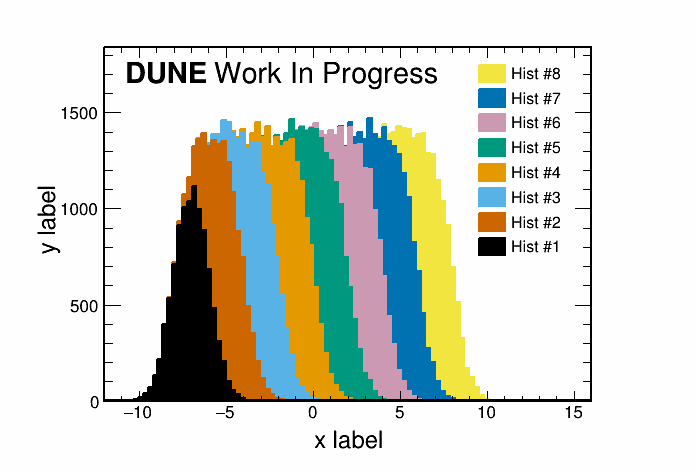

In [15]:
#-------------------------------------------------------------------
# enables us to reuse the histograms rather than regenerating every time
def GaussHists(nHists=dunestyle.colors.kColorCycles.at(ctypes.c_int(dunestyle.colors.Cycle.OkabeIto)).size()):
	hists = []
	f.SetParameter(0, 1)  # normalization constant
	f.SetParameter(2, 1)  # sigma
	for histIdx in range(nHists):
		ROOT.f.SetParameter(1, 2*int(histIdx) - (int(nHists)-1))
		hists.append(ROOT.TH1D("hs%u" % (histIdx+1), ";x label;y label", 100, -2*(nHists/2.+2), 2*nHists))
		hists[-1].FillRandom("f", 10000)
	return hists

#-------------------------------------------------------------------
def StackedExample(c, hists):
	# stacked histogram
	c.Clear()
	c.cd()
	leg = MakeLegend(0.68, 0.45, 0.9, 0.87)
	ROOT.SetOwnership(leg, False)

	hstack = ROOT.THStack("examplestack", ";x label; y label")
	ROOT.SetOwnership(hstack, False)
	if len(hists) == 0:
		hists = GaussHists()
	for histIdx, h in enumerate(hists):
		ROOT.SetOwnership(h, False)
		color = dunestyle.colors.NextColor(dunestyle.colors.Cycle.OkabeIto, 0 if histIdx==0 else -1)
		h.SetLineColor(color)
		h.SetFillColor(color)
		hstack.Add(h.Clone(h.GetName()))

		# we do this the hard way so the legend has the top-most histogram in the stack first
		leg.GetListOfPrimitives().AddFirst(ROOT.TLegendEntry(h, "Hist #%u" % (histIdx+1), "f"))
	hstack.Draw()
	leg.Draw()

	hstack.SetMaximum(hstack.GetMaximum()*1.25)   # make some room for the watermark
	dunestyle.CenterTitles(hstack.GetHistogram())
	dunestyle.WIP()
#-------------------------------------------------------------------

ROOT.Math.IntegratorOneDimOptions.SetDefaultIntegrator("Gauss")
hists = GaussHists()
StackedExample(c, hists)
c.Draw()

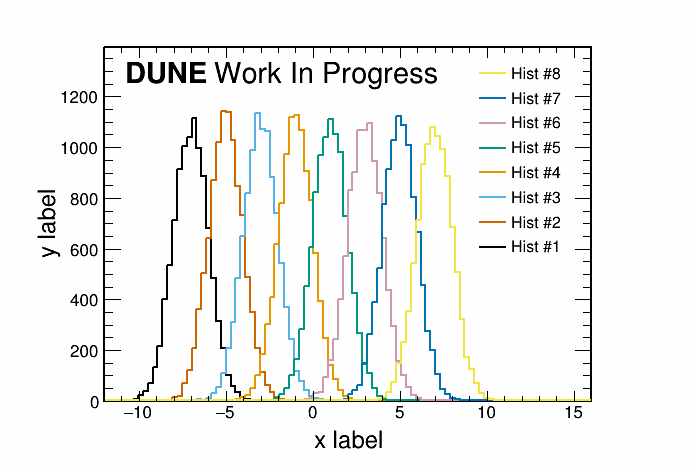

In [16]:
#-------------------------------------------------------------------
def OverlayExample(c, hists):
	c.Clear()
	c.cd()
	leg = MakeLegend(0.68, 0.45, 0.9, 0.87)
	ROOT.SetOwnership(leg, False)

	if len(hists) == 0:
		hists = GaussHists()
	hFirst = None
	for histIdx, h in enumerate(hists):
		color = dunestyle.colors.NextColor(dunestyle.colors.Cycle.OkabeIto, 0 if histIdx==0 else -1)
		h.SetLineColor(color)
		h.SetFillStyle(0)
		dunestyle.CenterTitles(h)
		newh = h.DrawCopy("" if histIdx == 0 else "same")
		if hFirst is None:
			hFirst = newh
		# we do this the hard way so the legend has the top-most histogram in the stack first
		leg.GetListOfPrimitives().AddFirst(ROOT.TLegendEntry(newh, "Hist #%u" % (histIdx+1), "l"))
	c.RedrawAxis();  # otherwise the last histogram drawn overlaps with the frame
	leg.Draw()

	hFirst.SetMaximum(hFirst.GetMaximum()*1.25) # make some space for the watermark
	dunestyle.WIP()
#-------------------------------------------------------------------

OverlayExample(c, hists)
c.Draw()